In [1]:

import torch
import json
import os
import numpy as np
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from pdf2image import convert_from_path
import tempfile
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_trf
import tensorflow as tf
import pandas as pd
from subprocess import call
import subprocess
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
import uuid
import gc
from tqdm import tqdm
from tqdm import trange
from time import sleep
import adabound

nlp = spacy.load("en_core_web_trf")


def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent


In [3]:


torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 5)
model.to(device)
model.load_state_dict(torch.load('./model_sgd_resnet50_pretrained.pt', map_location=torch.device('cpu')))
model.eval()




FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [4]:
torch.cuda.empty_cache()
test_img = cv2.imread("noisy_documents_dataset/testing_data/images/87093315_87093318.png" , cv2.IMREAD_COLOR)
test_img = cv2.cvtColor(test_img , cv2.COLOR_BGR2RGB).astype(np.float32)
test_img /= 255.0
test_img = torchvision.transforms.ToTensor()(test_img)
test_img.to(device)
test_img = test_img.unsqueeze(1).to(device)
print(test_img.shape)
output = model(test_img)
boxes = output[0]['boxes'].data.cpu().numpy()
test_img = test_img[0].permute(1 , 2 , 0).cpu().numpy()
print(boxes , len(boxes))

torch.Size([3, 1, 1000, 771])
[[339.31537  282.70364  370.3906   295.14716 ]
 [683.1347   764.39575  696.8484   784.1271  ]
 [683.3381   763.8616   697.61523  784.2573  ]
 [203.03238  546.4871   244.07513  559.5816  ]
 [268.6583    62.233894 306.04977   75.906105]
 [312.8182   756.50073  393.6161   773.8034  ]
 [605.40826   35.494484 655.8226    49.081367]
 [ 71.907    451.13034   90.78432  465.13647 ]
 [336.1837   391.4931   366.91858  403.45288 ]
 [ 44.6413   525.9617    74.393906 539.6016  ]
 [117.98644  411.06247  174.26318  426.3402  ]
 [ 47.185516 209.99834   77.76501  223.5433  ]
 [337.5835   326.05508  369.1917   338.57755 ]
 [334.5739   475.71548  367.57602  488.77365 ]
 [332.74554  610.8171   370.49667  624.0349  ]
 [ 66.643906 325.67673   96.0261   338.46097 ]
 [337.5115   326.11777  370.60287  338.3286  ]
 [473.6815   284.2179   500.60876  295.77832 ]
 [ 40.202923 682.40393   82.177765 696.78735 ]
 [197.76991  694.18915  255.70087  710.1739  ]
 [313.1478   526.3896   342.36

<ipython-input-6-cbcb4fabaa9c>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(test_img , (box[0] , box[1]) , (box[2] , box[3]) , (255 , 0 , 0))
<ipython-input-6-cbcb4fabaa9c>:6: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.putText(test_img, label_list[output[0]['labels'][counter]-1] , (box[0], box[1]) , cv2.FONT_HERSHEY_COMPLEX_SMALL , 1 , (0 , 255 , 0) , 2 , cv2.LINE_AA)


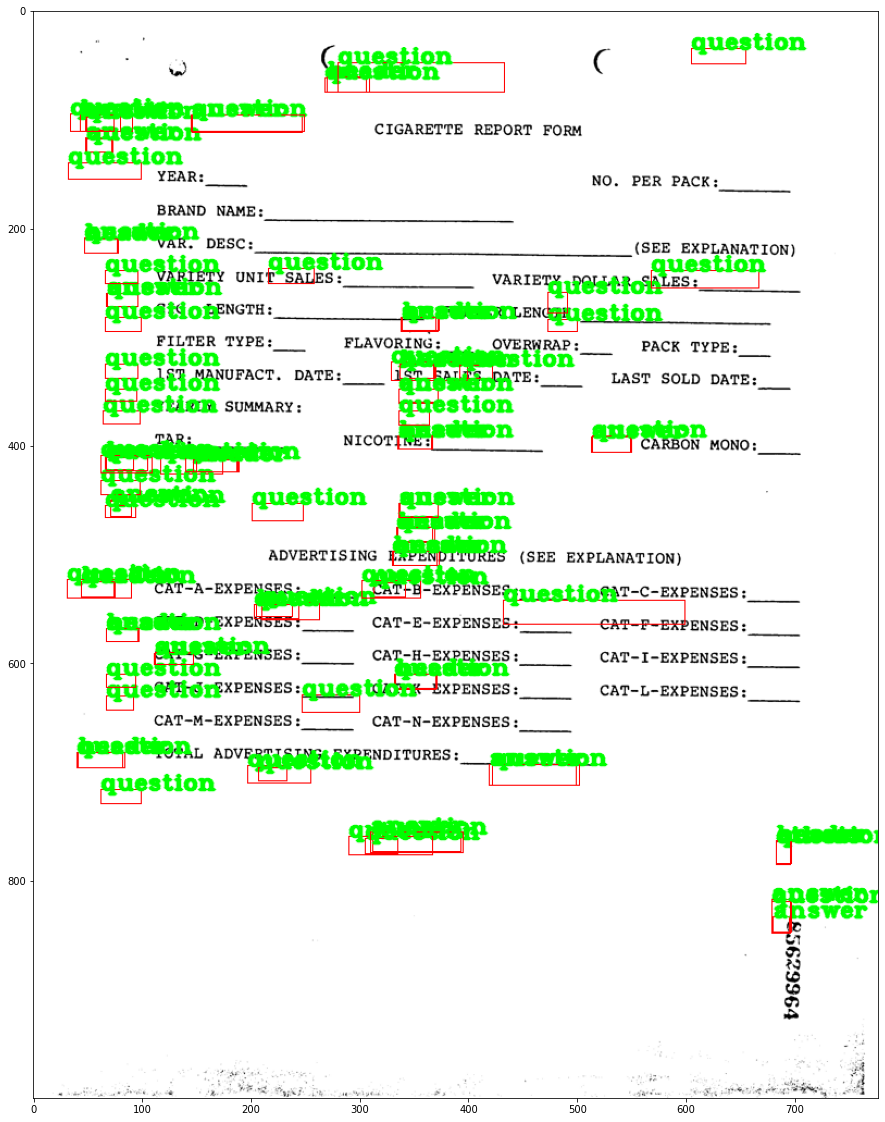

In [6]:
test_img = cv2.imread("noisy_documents_dataset/testing_data/images/85629964.png" , cv2.IMREAD_COLOR)
label_list = ["question", "answer" , "header", "other"]
counter = 0
for box in boxes:
    cv2.rectangle(test_img , (box[0] , box[1]) , (box[2] , box[3]) , (255 , 0 , 0))
    cv2.putText(test_img, label_list[output[0]['labels'][counter]-1] , (box[0], box[1]) , cv2.FONT_HERSHEY_COMPLEX_SMALL , 1 , (0 , 255 , 0) , 1 , cv2.LINE_AA)
    counter += 1


plt.figure(figsize=(20 , 20))
plt.imshow(test_img)
plt.show()
    

In [5]:
print(output[0]['labels'])

tensor([1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 4, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 2, 3, 1,
        2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 3, 3, 2, 1, 2, 1, 1, 3, 3, 1, 2,
        1, 2, 1, 1, 3, 3, 2, 2, 2, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 3, 1, 1, 2, 1,
        3, 1, 1, 2], device='cuda:0')
